# Predicting Volatility

**Project Goal**: 

In [12]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch import arch_model
from config import settings
from data import SQLRepository
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### 1. Prepare Data

#### Import

Connect to a database:

In [14]:
connection = sqlite3.connect(settings.db_name, check_same_thread=False)
repo = SQLRepository(connection=connection)

print("repo type:", type(repo))
print("repo.connection type:", type(repo.connection))

repo type: <class 'data.SQLRepository'>
repo.connection type: <class 'sqlite3.Connection'>


Read Ambuja Data From Database

In [15]:
df_ambuja = repo.read_table(table_name="AMBUJACEM.BSE", limit=2500)

print("df_ambuja type:", type(df_ambuja))
print("df_ambuja shape:", df_ambuja.shape)
df_ambuja.head()

df_ambuja type: <class 'pandas.core.frame.DataFrame'>
df_ambuja shape: (2500, 5)


,open,high,low,close,volume
date,,,,,
2024-06-05,576.75,601.75,550.35,599.05,493444.0
2024-06-04,670.60,670.60,518.00,557.40,1110009.0
2024-06-03,665.05,676.65,653.20,670.60,558604.0
2024-05-31,628.95,639.40,623.45,634.30,84665.0
2024-05-30,625.05,631.15,617.00,618.70,115283.0


#### Wrangle_data function

In [16]:
def wrangle_data(ticker, n_observations):

    """Extract table data from database. Calculate returns.

    Parameters
    ----------
    ticker : str
        The ticker symbol of the stock (also table name in database).

    n_observations : int
        Number of observations to return.

    Returns
    -------
    pd.Series
        Name will be `"return"`. There will be no `NaN` values.
    """
    # Get table from database
    df = repo.read_table(table_name=ticker, limit=n_observations + 1)


    # Sort DataFrame ascending by date
    df.sort_index(ascending=True, inplace=True)
    


    # Create "return" column
    df["return"] = df["close"].pct_change()*100
   


    # Return returns
    return df["return"].dropna()

Assertions to check the validity of the function:

In [17]:
y_ambuja = wrangle_data(ticker="AMBUJACEM.BSE", n_observations=2500)

# Is `y_ambuja` a Series?
assert isinstance(y_ambuja, pd.Series)

# Are there 2500 observations in the Series?
assert len(y_ambuja) == 2500

# Is `y_ambuja` name "return"?
assert y_ambuja.name == "return"

# Does `y_ambuja` have a DatetimeIndex?
assert isinstance(y_ambuja.index, pd.DatetimeIndex)

# Is index sorted ascending?
assert all(y_ambuja.index == y_ambuja.sort_index(ascending=True).index)

# Are there no `NaN` values?
assert y_ambuja.isnull().sum() == 0

y_ambuja.head()

date
2014-04-04   -0.781059
2014-04-07    2.706027
2014-04-09    0.646707
2014-04-10    1.166111
2014-04-11    1.787815
Name: return, dtype: float64

#### Read Suzlon Data From Database

In [18]:
y_suzlon = wrangle_data(ticker= "SUZLON.BSE", n_observations=2500)

print("y_suzlon type:", type(y_suzlon))
print("y_suzlon shape:", y_suzlon.shape)
y_suzlon.head()

y_suzlon type: <class 'pandas.core.series.Series'>
y_suzlon shape: (2500,)


date
2014-04-11   -0.469169
2014-04-15   -7.138047
2014-04-16   -4.931109
2014-04-17    1.906941
2014-04-21    6.736527
Name: return, dtype: float64

### 2. Explore

The volatility time series plot:

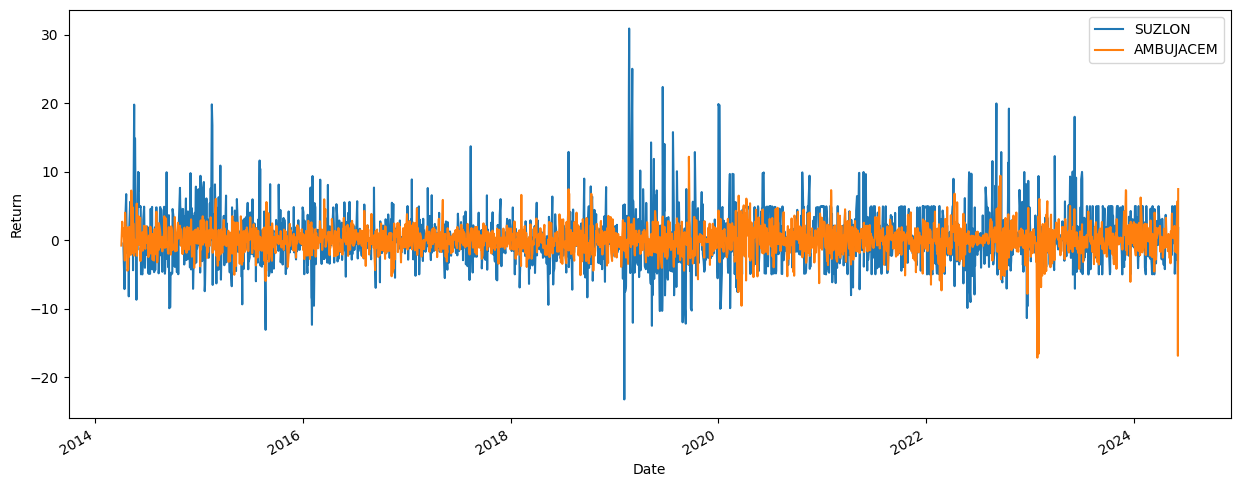

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for `df_suzlon` and `df_ambuja`
y_suzlon.plot(ax=ax, label="SUZLON")
y_ambuja.plot(ax=ax, label="AMBUJACEM")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

#### Conditional vs Unconditional Volatility

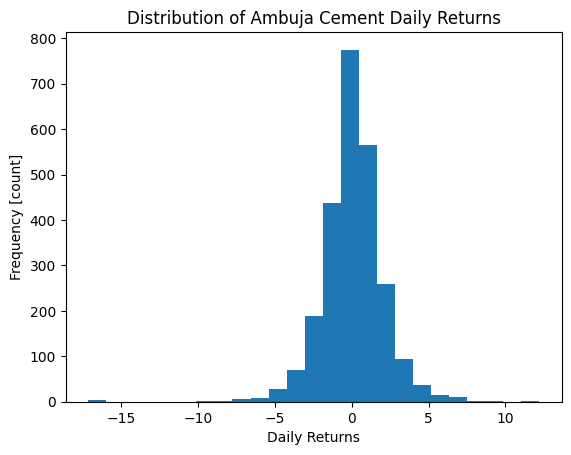

In [20]:
# Create histogram of `y_ambuja`, 25 bins
plt.hist(y_ambuja, bins=25)

# Add axis labels
plt.xlabel("Daily Returns")
plt.ylabel("Frequency [count]")


# Add title
plt.title("Distribution of Ambuja Cement Daily Returns")

plt.show();

- It turns out that returns follow an almost normal distribution, centered on 0. Volatility is the measure of the spread of these returns around the mean. 

- Volatility in finance is the same thing at standard deviation in statistics.

#### Calculating Daily Volatilty

In [21]:
suzlon_daily_volatility = y_suzlon.std()
ambuja_daily_volatility = y_ambuja.std()

print("Suzlon Daily Volatility:", suzlon_daily_volatility)
print("Ambuja Daily Volatility:", ambuja_daily_volatility)

Suzlon Daily Volatility: 3.883260637655722
Ambuja Daily Volatility: 1.9923977393446801


#### Annual Volatility